<a href="https://colab.research.google.com/github/Maxxx-VS/Test_task/blob/master/Sushi_test_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Тестовое задание

Постановка задачи:
В оффлайн-продажах важно оценивать предполагаемый поток клиентов и объем проданной продукции. В рамках данного тестового задания необходимо выполнить следующие шаги:
1.	На основании предоставленных исходных данных выберите и сформируйте список уникальных номенклатурных позиций, которые присутствуют в продажах.
2.	Подготовьте «силуэт продаж» – выявите и опишите характерный профиль продаж по каждой номенклатурной позиции, учитывая сезонность по дням недели и месяцам. Силуэт должен отражать типичные изменения объема продаж во времени.
3.	Используя сформированный силуэт продаж, подготовьте предварительный прогноз объема продаж на завтрашний день для каждой номенклатурной позиции (завтрашним считается день, следующий за днем сдачи тестового задания).
4.	С помощью инструментов машинного обучения проведите пост-обработку и корректировку предварительного прогноза, полученного по силуэту продаж, до более точного значения.
Предоставьте итоговый результат в виде таблицы с перечнем уникальных номенклатурных позиций и соответствующим прогнозом продаж. Дополнительно кратко опишите используемый подход и методику расчета и корректировки прогноза.
Из 3 представленных на выбор файлов (данные за прошлый год по трем разным торговым точкам), выбрать нужно только один (в решении можно использовать все три).

Описание переменных:
CloseTime – время чека
DishAmountInt – количество позиций (целевая переменная)
DishDiscountSumInt – сумма в рублях
DishName – название блюда
OpenDate.Typed– дата заказа
RestorauntGroup– название торговой точки

Рекомендации:
Цель данного тестового посмотреть на ход решения и рассуждений.
Укажите, какие переменные используются для построения силуэта продаж и модели, почему именно они, какие подходы используются в решении (приветствуется добавление собственных признаков). Никаких ограничений в плане выбора технологий прогнозирования нет (кроме, конечно, здравого смысла). Как итог нужно презентовать код решения с пояснениями (возможно, ноутбук в google colab или jupyter) и ответить на возникающие вопросы. Готовить слайды рр на данном этане не нужно.


## **0.** РАБОТА С ДАННЫМИ

> Развернуть



In [1]:
# Загрузка данных, сохраненных в Google Drive
from google.colab import drive
drive.mount('/content/drive')
print('''Необходимо указать  № торговой точки:

        №1 - Дианова, 14
        №2 - Энтузиастов, 2/1
        №3 - Патриса Лумумбы, 4б''', '\n')

choice = int(input("Выбор торговой точки: "))

Mounted at /content/drive
Необходимо указать  № торговой точки:

        №1 - Дианова, 14
        №2 - Энтузиастов, 2/1
        №3 - Патриса Лумумбы, 4б 

Выбор торговой точки: 1


In [2]:
# Формируем путь к Excel файлу
address_list = ['id_точки 16.xlsx', 'id_точки 34.xlsx', 'id_точки 597.xlsx']
path = '/content/drive/MyDrive/Sushi_test_task/' + address_list[choice-1]
print(path)

/content/drive/MyDrive/Sushi_test_task/id_точки 16.xlsx


In [3]:
# Создаем датафрейм
import pandas as pd
df = pd.read_excel(path)

In [4]:
# Вывод структуры датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326619 entries, 0 to 326618
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CloseTime           326619 non-null  datetime64[ns]
 1   DishAmountInt       326619 non-null  int64         
 2   DishDiscountSumInt  326619 non-null  int64         
 3   DishName            326619 non-null  object        
 4   RestorauntGroup     326619 non-null  object        
 5   OpenDate.Typed      326619 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 15.0+ MB


In [5]:
# Изучим статистические показатели датафрейма
# count: количество непустых значений, mean: среднее значение, std: стандартное отклонение, min: минимальное значение, 25%, 50%, 75%: квартили, max: максимальное значение
df.describe()

,CloseTime,DishAmountInt,DishDiscountSumInt,OpenDate.Typed
count,326619,326619.000000,326619.000000,326619
mean,2024-08-14 22:06:43.376683776,2.549610,160.189435,2024-08-14 05:28:06.996776448
min,2024-02-01 10:03:47,0.000000,0.000000,2024-02-01 00:00:00
25%,2024-05-10 17:31:41,1.000000,13.000000,2024-05-10 00:00:00
50%,2024-08-16 15:27:35,1.000000,82.000000,2024-08-16 00:00:00
75%,2024-11-15 16:27:12,3.000000,190.000000,2024-11-15 00:00:00
max,2025-02-28 21:17:26,60.000000,6500.000000,2025-02-28 00:00:00
std,NaN,2.699514,240.291049,NaN


In [6]:
# Вывод размерности датафрейма
df.shape

(326619, 6)

In [7]:
# Вывод наименования столбцов датафрейма
df.columns

Index(['CloseTime', 'DishAmountInt', 'DishDiscountSumInt', 'DishName',
       'RestorauntGroup', 'OpenDate.Typed'],
      dtype='object')

In [8]:
# Переименуем столбец для исключения точки в названии
df = df.rename(columns={'OpenDate.Typed': 'OpenDate_Typed'})

In [9]:
# Удаляем строки с пустыми значениями в датафрейме и со значениями NaN
import numpy as np
df = df.replace('', np.nan).dropna()

In [10]:
# Удаляем строки с нулевыми значениями в датафрейме
collumns_to_check = ['DishAmountInt', 'DishDiscountSumInt']
df = df[(df[collumns_to_check] >= 1).all(axis=1)]

In [11]:
# Проверяем полноту данных по месяцам за 2024 год
df_2024 = df[df['OpenDate_Typed'].dt.year == 2024]

month_2024 = df_2024.groupby(df_2024['OpenDate_Typed'].dt.to_period('M'))['DishAmountInt'].sum().reset_index()
print(month_2024)

   OpenDate_Typed  DishAmountInt
0         2024-02          61824
1         2024-03          68165
2         2024-04          60302
3         2024-05          60774
4         2024-06          61361
5         2024-07          62756
6         2024-08          71238
7         2024-09          66415
8         2024-10          69481
9         2024-11          60102
10        2024-12          59830


In [12]:
# Проверяем полноту данных по месяцам за 2025 год
df_2025 = df[df['OpenDate_Typed'].dt.year == 2025]

month_2025 = df_2025.groupby(df_2025['OpenDate_Typed'].dt.to_period('M'))['DishAmountInt'].sum().reset_index()
print(month_2025)

  OpenDate_Typed  DishAmountInt
0        2025-01          58457
1        2025-02          65416


In [13]:
# Удаляем записи за февраль 2025 год
df = df[~((df['OpenDate_Typed'].dt.year == 2025) & (df['OpenDate_Typed'].dt.month == 2))]

In [14]:
# Учитывая сезонную схожесть января 2024 и января 2025 проведем экстраполяцию данных с 2025 на 2024 год
df['OpenDate_Typed'] = df['OpenDate_Typed'].apply(lambda x: x.replace(year=2024))

In [15]:
# Проерка исправленного датафрейма
df_2024 = df[df['OpenDate_Typed'].dt.year == 2024]

month_2024 = df_2024.groupby(df_2024['OpenDate_Typed'].dt.to_period('M'))['DishAmountInt'].sum().reset_index()
print(month_2024)

   OpenDate_Typed  DishAmountInt
0         2024-01          58457
1         2024-02          61824
2         2024-03          68165
3         2024-04          60302
4         2024-05          60774
5         2024-06          61361
6         2024-07          62756
7         2024-08          71238
8         2024-09          66415
9         2024-10          69481
10        2024-11          60102
11        2024-12          59830


In [16]:
# Вывод структуры датафрейма после очистки от неинформативных значений
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 296672 entries, 721 to 325532
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   CloseTime           296672 non-null  datetime64[ns]
 1   DishAmountInt       296672 non-null  int64         
 2   DishDiscountSumInt  296672 non-null  int64         
 3   DishName            296672 non-null  object        
 4   RestorauntGroup     296672 non-null  object        
 5   OpenDate_Typed      296672 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 15.8+ MB


In [17]:
# Учитывая, что данные относятся к одной торговой точке - удаляем признак "RestorauntGroup"
df = df.drop("RestorauntGroup", axis=1)
# Удаляем дублирующий признак "CloseTime"
df = df.drop("CloseTime", axis=1)

In [18]:
df

,DishAmountInt,DishDiscountSumInt,DishName,OpenDate_Typed
721,1,1,&Набор Калифорния подаро 8рол,2024-02-13
722,1,1,&Набор Популярный Дуэт 8рол,2024-02-13
723,1,1,&Набор Популярный Дуэт 8рол,2024-02-13
724,4,100,Аризона 10рол,2024-02-13
725,4,100,Аризона 10рол,2024-02-13
...,...,...,...,...
325528,2,176,Каппа Маки 8рол сеть,2024-02-25
325529,3,75,Аризона 10 рол,2024-02-25
325530,1,13,ИМБИРЬ ЗАВОДСКАЯ ФАСОВКА,2024-02-25
325531,1,13,Контейнер маленький одн,2024-02-25


In [19]:
# Объединяем данные с одинаковыми признаками 'OpenDate_Typed', 'DishName' и складываем 'DishAmountInt' и 'DishDiscountSumInt'
df = df.groupby(['DishName', 'OpenDate_Typed']).agg({
    'DishAmountInt': 'sum',
    'DishDiscountSumInt': 'sum'}).reset_index()

In [20]:
# Меняем тип данных признака 'CloseTime'
df['OpenDate_Typed'] = pd.to_datetime(df['OpenDate_Typed'])

# Извлекаем компоненты и раскладываем на год/месяц/день
df['Year'] = df['OpenDate_Typed'].dt.year
df['Month'] = df['OpenDate_Typed'].dt.month
df['Week'] = df['OpenDate_Typed'].dt.isocalendar().week
df['Weekday'] = df['OpenDate_Typed'].dt.dayofweek

In [21]:
# Проверка на соответсвие всех целочисленных значений в столбцах 'DishAmountInt', 'DishDiscountSumInt'
def check_column_type_int(df, column_name, expected_type):
    return all(isinstance(item, expected_type) for item in df[column_name])

print(check_column_type_int(df, 'DishAmountInt', int))  # True
print(check_column_type_int(df, 'DishDiscountSumInt', int))  # True
print(check_column_type_int(df, 'DishName', str))  # True


# Проверка на соответсвие всех datetime значений в столбце 'OpenDate_Typed'
def is_datetime_column(df, column_name):
    return pd.api.types.is_datetime64_ns_dtype(df[column_name])

print(is_datetime_column(df, 'OpenDate_Typed'))  # True

True
True
True
True


In [22]:
df

,DishName,OpenDate_Typed,DishAmountInt,DishDiscountSumInt,Year,Month,Week,Weekday
0,&Набор Калифорния подаро 8рол,2024-02-01,3,3,2024,2,5,3
1,&Набор Калифорния подаро 8рол,2024-02-02,1,1,2024,2,5,4
2,&Набор Калифорния подаро 8рол,2024-02-03,3,3,2024,2,5,5
3,&Набор Калифорния подаро 8рол,2024-02-04,5,5,2024,2,5,6
4,&Набор Калифорния подаро 8рол,2024-02-05,2,2,2024,2,6,0
...,...,...,...,...,...,...,...,...
22674,Ясай 10рол,2024-12-27,2,44,2024,12,52,4
22675,Ясай 10рол,2024-12-28,34,748,2024,12,52,5
22676,Ясай 10рол,2024-12-29,15,330,2024,12,52,6
22677,Ясай 10рол,2024-12-30,10,220,2024,12,1,0


In [23]:
df.describe()

,OpenDate_Typed,DishAmountInt,DishDiscountSumInt,Year,Month,Week,Weekday
count,22679,22679.000000,22679.000000,22679.0,22679.000000,22679.0,22679.000000
mean,2024-07-04 14:34:11.836500480,33.542264,2132.719741,2024.0,6.612284,26.787689,3.038847
min,2024-01-01 00:00:00,1.000000,1.000000,2024.0,1.000000,1.0,0.000000
25%,2024-04-04 00:00:00,4.000000,299.000000,2024.0,4.000000,14.0,1.000000
50%,2024-07-08 00:00:00,15.000000,855.000000,2024.0,7.000000,27.0,3.000000
75%,2024-10-05 00:00:00,42.000000,2200.000000,2024.0,10.000000,40.0,5.000000
max,2024-12-31 00:00:00,1162.000000,149080.000000,2024.0,12.000000,52.0,6.000000
std,NaN,51.631513,3608.600768,0.0,3.467332,15.154522,1.989530


## **1.** СПИСОК УНИКАЛЬНЫХ НОМЕНКЛАТУРНЫХ ПОЗИЦИЙ

> Развернуть

In [24]:
# Обращаемся к столбцу и и применяем метод .unique()
unique_values = df['DishName'].unique()
print(f'Общее количество уникальных номенклатурных позиций = {len(unique_values)} ед.', '\n')
unique_values

Общее количество уникальных номенклатурных позиций = 172 ед. 



array(['&Набор Калифорния подаро 8рол', '&Набор Калифорния подарок 8рол',
       '&Набор Популярный Дуэт 8рол', '&Набор Приведи друга Бостон 8рол',
       '&Онигири креветка подарок', 'Rollbox Аппетитный 10шт',
       'Rollbox Любимый 10шт', 'Rollbox Популярный 10шт',
       'Rollbox Суши Бокс 5шт', 'Rollbox Филадельфия 10шт',
       'Rollbox Фитнес-Бокс 13шт', 'Rollbox Фиш микс 10шт',
       'Амазонка запеч 10рол', 'Амазонка запеч МСК',
       'Амазонка запеч ролл10', 'Аризона 10 рол', 'Аризона 10рол',
       'Аризона МСК ролл', 'Бансай 10рол', 'Бансай МСК ролл',
       'Бонито 10рол', 'Бонито МСК ролл', 'Бостон 10рол',
       'Бостон МСК ролл', 'Босфор запеч 10рол', 'Босфор запеч МСК',
       'ВАСАБИ ЗАВОДСКАЯ ФАСОВКА', 'ВИЛОЧКА В УПАКОВКЕ ОДНОР',
       'ВИЛОЧКА ОДНОР', 'ВОДА Б/Г 0,33л', 'ВОДА Б/Г СУШИ - МАРКЕТ 0,33л',
       'ВОДА В АССОРТ 0,5 л', 'Валенсия МСК ролл',
       'Вок с беконом в сливочном соусе 330гр',
       'Вок с беконом в терияки соусе 330гр',
       'Вок с креветк

## **2.** СИЛУЭТ ПРОДАЖ

> Развернуть

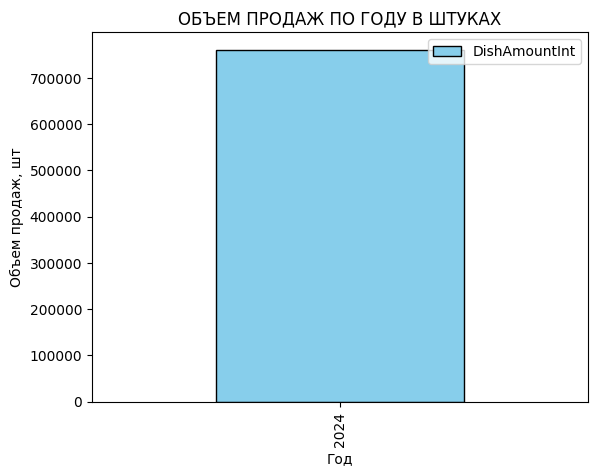

In [25]:
# Графически изображаем силуэт продаж с отбором по временным критериям
import matplotlib.pyplot as plt

# Группировка данных по годам
year = df.groupby('Year')['DishAmountInt'].sum().reset_index()

# Вывод гистограммы
year.plot(kind='bar', x='Year', y='DishAmountInt', color='skyblue', edgecolor='black')
plt.title('ОБЪЕМ ПРОДАЖ ПО ГОДУ В ШТУКАХ')
plt.xlabel('Год')
plt.ylabel('Объем продаж, шт')
plt.show()

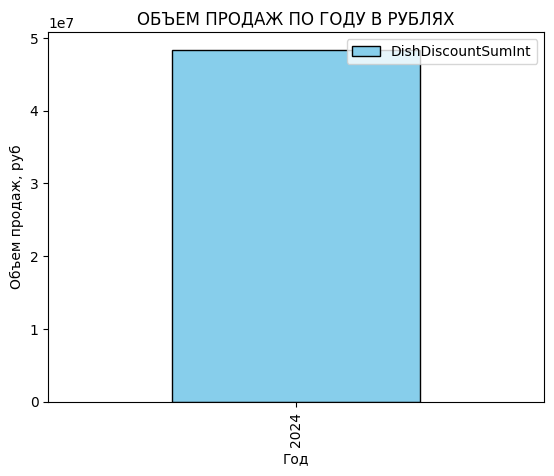

In [26]:
# Группировка данных по годам
year = df.groupby('Year')['DishDiscountSumInt'].sum().reset_index()

# Вывод гистограммы
year.plot(kind='bar', x='Year', y='DishDiscountSumInt', color='skyblue', edgecolor='black')
plt.title('ОБЪЕМ ПРОДАЖ ПО ГОДУ В РУБЛЯХ')
plt.xlabel('Год')
plt.ylabel('Объем продаж, руб')
plt.show()

In [ ]:
monty_list = {
    1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель',
    5: 'май', 6: 'июнь', 7: 'июль', 8: 'август',
    9: 'сентябрь', 10: 'октябрь', 1: 'ноябрь', 12: 'декабрь',
}

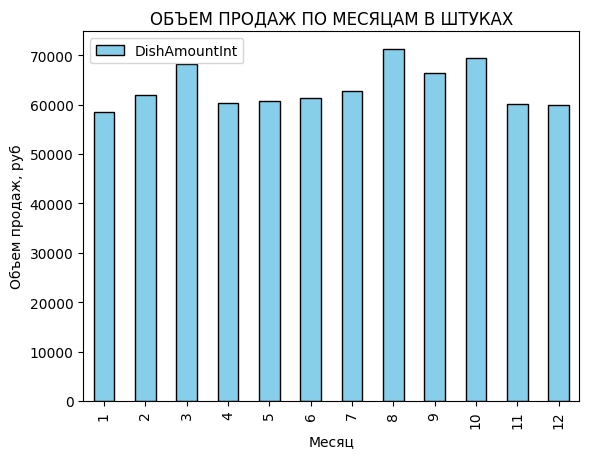

In [37]:
# Группировка данных по месяцам
monty = df.groupby('Month')['DishAmountInt'].sum().reset_index()

# Вывод гистограммы
monty.plot(kind='bar', x='Month', y='DishAmountInt', color='skyblue', edgecolor='black')
plt.bar()
plt.title('ОБЪЕМ ПРОДАЖ ПО МЕСЯЦАМ В ШТУКАХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, руб')
plt.show()

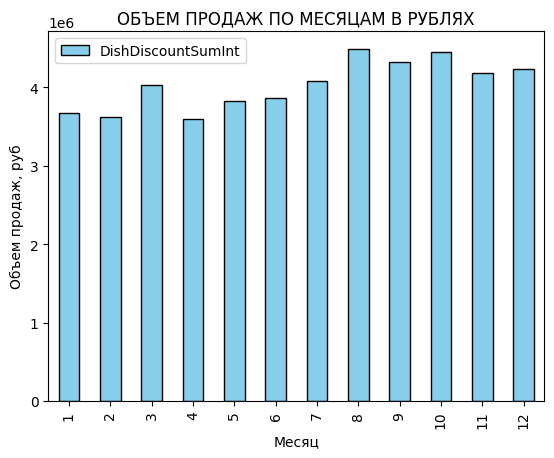

In [38]:
# Группировка данных по месяцам
monty = df.groupby('Month')['DishDiscountSumInt'].sum().reset_index()

# Вывод гистограммы
monty.plot(kind='bar', x='Month', y='DishDiscountSumInt', color='skyblue', edgecolor='black')

plt.title('ОБЪЕМ ПРОДАЖ ПО МЕСЯЦАМ В РУБЛЯХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, руб')
plt.show()

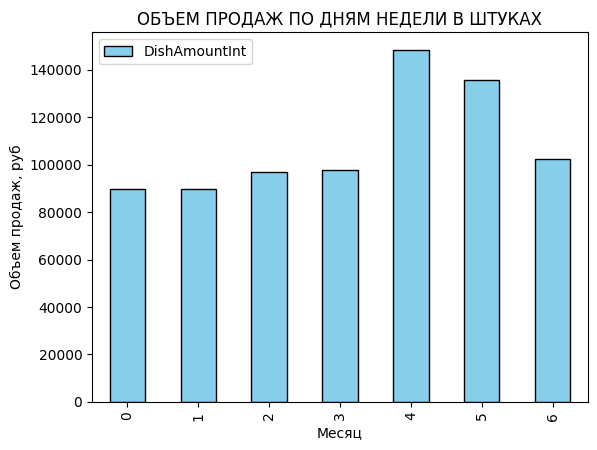

In [42]:
# Группировка данных по дням недели
weekday = df.groupby('Weekday')['DishAmountInt'].sum().reset_index()

# Вывод гистограммы
weekday.plot(kind='bar', x='Weekday', y='DishAmountInt', color='skyblue', edgecolor='black')

plt.title('ОБЪЕМ ПРОДАЖ ПО ДНЯМ НЕДЕЛИ В ШТУКАХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, руб')
plt.show()

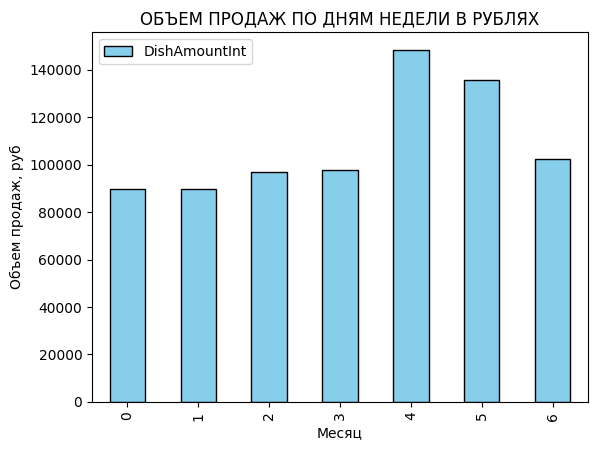

In [41]:
# Группировка данных по дням недели
weekday = df.groupby('Weekday')['DishAmountInt'].sum().reset_index()

# Вывод гистограммы
weekday.plot(kind='bar', x='Weekday', y='DishAmountInt', color='skyblue', edgecolor='black')

plt.title('ОБЪЕМ ПРОДАЖ ПО ДНЯМ НЕДЕЛИ В РУБЛЯХ')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж, руб')
plt.show()